In [1]:
from __future__ import print_function
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras.layers import Layer
import jlr_util
import numpy as np
from keras import backend as K
np.set_printoptions(precision=2)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
class TrainableCombinationLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CombinationLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        #weight is trained
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.output_dim, input_shape[1]),
            initializer='uniform',
            trainable=True,
            #constraint=keras.constraints.UnitNorm(axis=1)
        )
        super(CombinationLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim, input_shape[0][2])
    
    def call(self, x):
        prod = K.batch_dot(self.kernel, x, axes=[2,1])
        prod = tf.where(tf.is_nan(prod), tf.zeros_like(prod), prod)
        return prod

In [3]:
class CombinationLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CombinationLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(CombinationLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim, input_shape[0][2])
    
    def call(self, inp):
        x, kernel = inp
        prod = K.batch_dot(kernel, x, axes=[2,1])
        prod = tf.where(tf.is_nan(prod), tf.zeros_like(prod), prod)
        return prod

In [4]:
def minkowski_init(shape, dtype=None):
    return K.cast(tf.diag([1,1,1,-1]), dtype=K.floatx())


class InnerpProductLayer(Layer):
    def __init__(self, **kwargs):
        super(BilinearLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(4, 4),
            initializer=minkowski_init,
            trainable=False,
            #constraint=keras.constraints.UnitNorm(axis=1),
        )
        super(BilinearLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[1][1], input_shape[0][1])
    
    def matprod(self, x1, x2):
        x1t = tf.transpose(x1,[0,2,1])
        a = tf.transpose(K.dot(self.kernel, x1t), [1,0,2])
        prod = K.batch_dot(x2, a, axes=[2,1])
        return prod
    
    def norms(self, x):
        p = self.matprod(x, x)
        return tf.matrix_diag_part(p)
    
    def call(self, xs):
        x1, x2 = xs
        #print("norm", x1n.shape)
        #x1n = K.repeat(self.norms(x1), x1.shape[1])
        #x2n = K.repeat(self.norms(x2), x1.shape[1])
        prod = self.matprod(x1, x2)
        #prod = tf.divide(prod, x1n)
        #prod = tf.divide(prod, x2n)
        #prod = tf.where(tf.is_nan(prod), tf.zeros_like(prod), prod)
        return prod

In [8]:
X, Xadditional, Xmatch, y = jlr_util.load_data("data/processed/data_fh_match.npz")

In [1477]:
X_train = X[0:15000, :4*9].reshape(15000, 9,4)
X_test = X[15000:23000, :4*9].reshape(8000, 9,4)

In [1478]:
Xparton_train = Xparton[0:15000, :].reshape(15000, 4,4)
Xparton_test = Xparton[15000:23000, :].reshape(8000, 4,4)

In [1651]:
#combination layer model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name="input")
f1 = keras.layers.Flatten()(inputs)

bn = keras.layers.BatchNormalization()(f1)
d = keras.layers.Dense(128, activation="tanh")(bn)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(128, activation="tanh")(d)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(128, activation="tanh")(d)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(20*9, activation="linear")(d)
d = keras.layers.Reshape((20,9))(d)
p = CombinationLayer(20, name="comb1")([inputs, d])
f2 = keras.layers.Flatten()(p)

bn = keras.layers.BatchNormalization()(f2)
d = keras.layers.Dense(128, activation="tanh")(bn)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(128, activation="tanh")(d)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(128, activation="tanh")(d)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(4*20, activation="linear")(d)
d = keras.layers.Reshape((4,20))(d)
p = CombinationLayer(4, name="comb2")([p, d])
f3 = keras.layers.Flatten()(p)

c = keras.layers.Concatenate()([f1, f2, f3])

bn = keras.layers.BatchNormalization()(c)
d = keras.layers.Dense(128, activation="tanh")(bn)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(128, activation="tanh")(d)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(128, activation="tanh")(d)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(4*4, activation="linear")(d)
r = keras.layers.Reshape((4,4))(d)

#r = keras.layers.Flatten()(p)

model = keras.models.Model(inputs=inputs, outputs=r)

opt = keras.optimizers.Adam(lr=0.005)
model.compile(opt, loss="mse")

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 9, 4)         0                                            
__________________________________________________________________________________________________
flatten_412 (Flatten)           (None, 36)           0           input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 36)           144         flatten_412[0][0]                
__________________________________________________________________________________________________
dense_494 (Dense)               (None, 128)          4736        batch_normalization_115[0][0]    
__________________________________________________________________________________________________
dropout_17

In [1652]:
#baseline feedforward model
inputs2 = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name="input")
f1 = keras.layers.Flatten()(inputs2)

d = keras.layers.BatchNormalization()(f1)

for i in range(4):
    d = keras.layers.Dense(128, activation="tanh")(d)
    d = keras.layers.Dropout(0.5)(d)

d = keras.layers.Dense(4*4, activation="linear")(d)
r = keras.layers.Reshape((4,4))(d)

model2 = keras.models.Model(inputs=inputs2, outputs=r)
opt = keras.optimizers.Adam(lr=0.005)
model2.compile(opt, loss="mse")
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 9, 4)              0         
_________________________________________________________________
flatten_415 (Flatten)        (None, 36)                0         
_________________________________________________________________
batch_normalization_118 (Bat (None, 36)                144       
_________________________________________________________________
dense_506 (Dense)            (None, 128)               4736      
_________________________________________________________________
dropout_182 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_507 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_183 (Dropout)        (None, 128)               0         
__________

In [1653]:
ret2 = model2.fit(X_train, Xparton_train, validation_data=(X_test, Xparton_test), epochs=50, batch_size=100)

Train on 15000 samples, validate on 8000 samples
Epoch 1/50
15000/15000 [==============================] - 12s 780us/step - loss: 25945.7193 - val_loss: 23776.2517
Epoch 2/50
15000/15000 [==============================] - 2s 105us/step - loss: 22065.6061 - val_loss: 21062.0330
Epoch 3/50
15000/15000 [==============================] - 2s 111us/step - loss: 20106.4667 - val_loss: 19553.7099
Epoch 4/50
15000/15000 [==============================] - 2s 113us/step - loss: 19069.6128 - val_loss: 18683.0346
Epoch 5/50
15000/15000 [==============================] - 2s 106us/step - loss: 18459.7455 - val_loss: 18137.7199
Epoch 6/50
15000/15000 [==============================] - 2s 108us/step - loss: 18037.1188 - val_loss: 17805.3394
Epoch 7/50
15000/15000 [==============================] - 2s 109us/step - loss: 17817.8646 - val_loss: 17521.2921
Epoch 8/50
15000/15000 [==============================] - 2s 109us/step - loss: 17655.6583 - val_loss: 17341.5905
Epoch 9/50
15000/15000 [==============

In [1654]:
ret = model.fit(X_train, Xparton_train, validation_data=(X_test, Xparton_test), epochs=50, batch_size=100)

Train on 15000 samples, validate on 8000 samples
Epoch 1/50
15000/15000 [==============================] - 13s 839us/step - loss: 25960.6398 - val_loss: 23870.4041
Epoch 2/50
15000/15000 [==============================] - 3s 179us/step - loss: 21987.5254 - val_loss: 21035.4649
Epoch 3/50
15000/15000 [==============================] - 3s 183us/step - loss: 20016.5836 - val_loss: 19543.7357
Epoch 4/50
15000/15000 [==============================] - 3s 172us/step - loss: 18946.0853 - val_loss: 18669.0332
Epoch 5/50
15000/15000 [==============================] - 3s 178us/step - loss: 18289.2915 - val_loss: 18106.8027
Epoch 6/50
15000/15000 [==============================] - 3s 172us/step - loss: 17897.6845 - val_loss: 17762.9656
Epoch 7/50
15000/15000 [==============================] - 3s 176us/step - loss: 17641.5178 - val_loss: 17497.1408
Epoch 8/50
15000/15000 [==============================] - 3s 168us/step - loss: 17481.1503 - val_loss: 17316.9062
Epoch 9/50
15000/15000 [==============

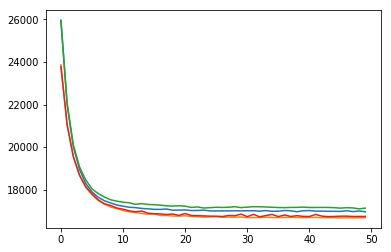

In [1655]:
plt.plot(ret.history["loss"])
plt.plot(ret.history["val_loss"])

plt.plot(ret2.history["loss"])
plt.plot(ret2.history["val_loss"])

In [1656]:
[(il, l) for il, l in enumerate(model.layers)]

[(0, <keras.engine.topology.InputLayer at 0x13d30b310>),
 (1, <keras.layers.core.Flatten at 0x168c80910>),
 (2, <keras.layers.normalization.BatchNormalization at 0x167252250>),
 (3, <keras.layers.core.Dense at 0x167289950>),
 (4, <keras.layers.core.Dropout at 0x167289990>),
 (5, <keras.layers.core.Dense at 0x167280510>),
 (6, <keras.layers.core.Dropout at 0x1673727d0>),
 (7, <keras.layers.core.Dense at 0x16747df50>),
 (8, <keras.layers.core.Dropout at 0x16748c650>),
 (9, <keras.layers.core.Dense at 0x167a589d0>),
 (10, <keras.layers.core.Reshape at 0x167a67f10>),
 (11, <__main__.CombinationLayer at 0x167e955d0>),
 (12, <keras.layers.core.Flatten at 0x167e95690>),
 (13, <keras.layers.normalization.BatchNormalization at 0x167ea3d50>),
 (14, <keras.layers.core.Dense at 0x167fe2b90>),
 (15, <keras.layers.core.Dropout at 0x167fe2fd0>),
 (16, <keras.layers.core.Dense at 0x168043510>),
 (17, <keras.layers.core.Dropout at 0x168139850>),
 (18, <keras.layers.core.Dense at 0x168205d50>),
 (19, <k

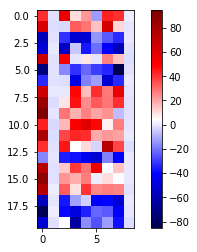

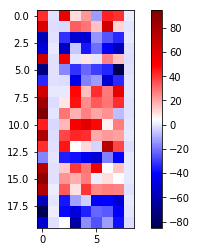

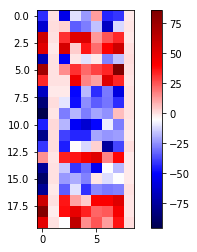

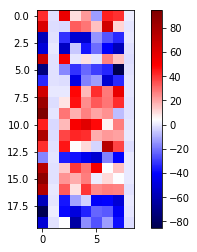

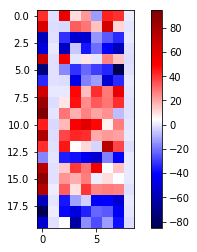

In [1657]:
l = model.layers[10]
for i in range(5):
    plt.figure()
    m = l.output.eval(session=K.get_session(), feed_dict={inputs: X_test[i:i+1]})[0, :, :]
    plt.imshow(m, cmap="seismic")
    plt.colorbar()

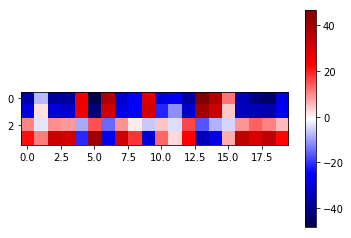

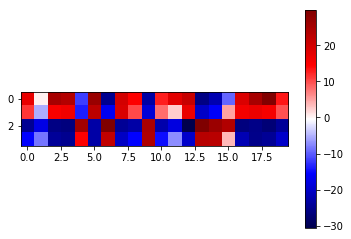

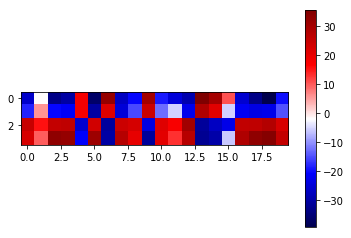

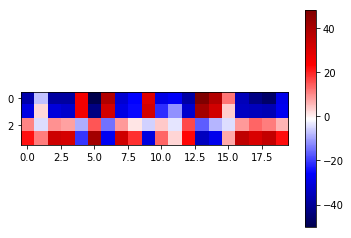

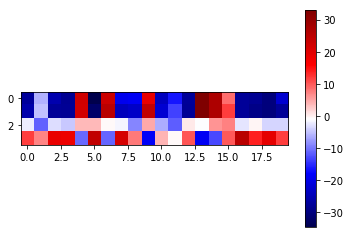

In [1630]:
l = model.layers[21]
for i in range(5):
    plt.figure()
    m = l.output.eval(session=K.get_session(), feed_dict={inputs: X_test[i:i+1]})[0, :, :]
    plt.imshow(m, cmap="seismic")
    plt.colorbar()

In [1575]:
preds = model.predict(Xtransf[:10])

In [1576]:
trues = Xparton_transf[:10]